<a href="https://colab.research.google.com/github/bwsi-hadr/05-Intro-to-Data-Science/blob/master/05_Intro_to_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Data Science
Data science is a broad discipline, generally using models and data to infer, predict, and describe phenomena.

There are a ton of techniques in data science: a full college degree's worth. So we will focus on a few methods that may be applicable for geospatial analysis for disaster assessment and response.

We'll be using [sci-kit learn](https://scikit-learn.org/stable/index.html) for most of our classification tasks. 

In [0]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.datasets import make_blobs
import networkx as nx
try:
  import osmnx as ox
except:
  # osmnx depends on the system package libspatialindex
  !apt install libspatialindex-dev
  !pip install osmnx
  import osmnx as ox

try: 
  import geopandas as gpd
except: 
  !pip install geopandas 
  import geopandas as gpd
  
try:
  import contextily as ctx 
except:
  # install dependencies for contextily
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  # install contextily
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
  import contextily as ctx
  
import fiona
from shapely.geometry import Point, LineString, Polygon
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [0]:
# Coordinates of the MIT main campus in Decimal Degrees
coordinates = [(-71.092562, 42.357602), (-71.080155, 42.361553),
               (-71.089817, 42.362584), (-71.094688, 42.360198)]

# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)

# convert to meters (UTM) from latlong
poly_m, poly_crs_m = ox.project_geometry(poly)
print(poly_crs_m)

# put a buffer of 1 mile (1609.34 m) to get everything w/in 1 mile
poly_with_buffer_m = poly_m.buffer(1609.34)
# get the bounding box
poly_with_buffer_m = poly_with_buffer_m.envelope

# convert back to lat-long
poly_with_buffer_ll, poly_crs_ll = ox.project_geometry(poly_with_buffer_m, 
                                                        crs=poly_crs_m, 
                                                        to_crs=fiona.crs.from_epsg(4326), 
                                                        to_latlong=True)

# get all walkable roads within poly
walkable_roads_near_mit = ox.graph_from_polygon(poly_with_buffer_ll, 
                                       network_type='walk',
                                       clean_periphery=True)

# we can get the footprints of objects within this poly
building_footprints = ox.footprints_from_polygon(poly_with_buffer_ll, 
                                                 footprint_type='building')

# drop rows where there's no shape info
building_footprints = building_footprints.loc[~building_footprints['geometry'].isna()]

# project to UTM
building_footprints_proj = ox.project_gdf(building_footprints)




+proj=utm +zone=19 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


In [0]:
# get the centers of the footprints for easier classification
building_centers = building_footprints_proj.copy()
building_centers['geometry'] = building_footprints['geometry'].centroid

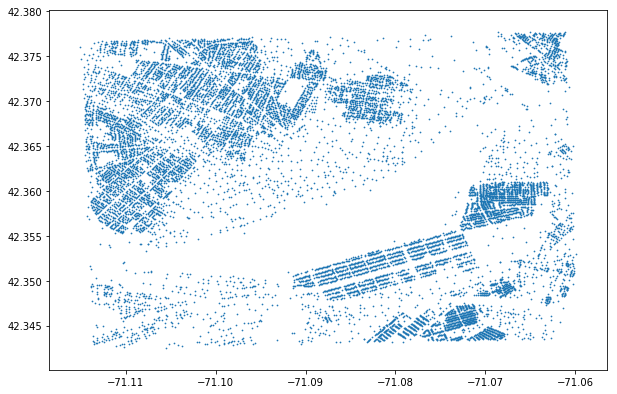

In [0]:
building_centers.plot(figsize=[10,10], markersize=0.5)

# Clustering
Clustering looks for "groups" within the data. This is an example of unsupervised learning, where the "true" classification of the data is not provided to the algorithm.

This is good for exploring the structure of the data. 

## k-Means
k-means partitions groups into _k_ clusters, where each observation belongs to the cluster with the nearest mean. This divides the space into [Voronoi cells](https://en.wikipedia.org/wiki/Voronoi_cell).

There are a number of assumptions that the k-means classifier makes, which could make it fail. Below we'll illustrate some of those assumptions.

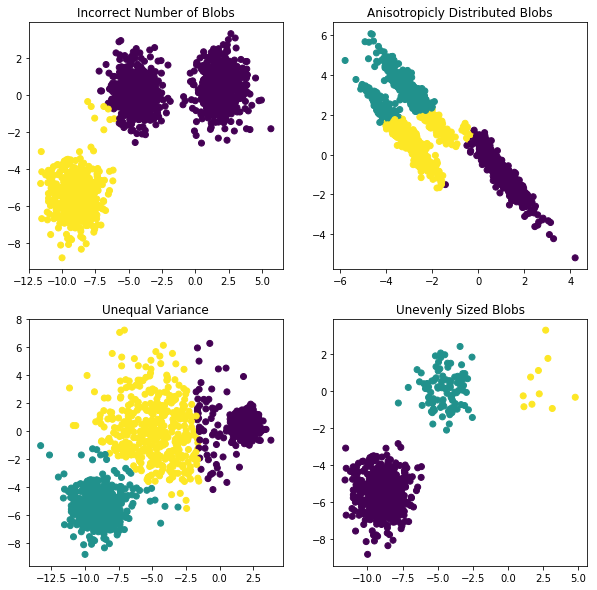

In [0]:
plt.figure(figsize=(10, 10))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
# anisotropic means there data spreads more in one direction than the other
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()

### Applying to our building data

In [0]:
point_coords = zip(building_centers['geometry'].x, building_centers['geometry'].y)
point_coords = np.array([[x,y] for x,y in point_coords])

In [0]:
kmeans_2 = KMeans(n_clusters=2).fit_predict(point_coords)
kmeans_3 = KMeans(n_clusters=3).fit_predict(point_coords)
kmeans_4 = KMeans(n_clusters=4).fit_predict(point_coords)
kmeans_5 = KMeans(n_clusters=5).fit_predict(point_coords)

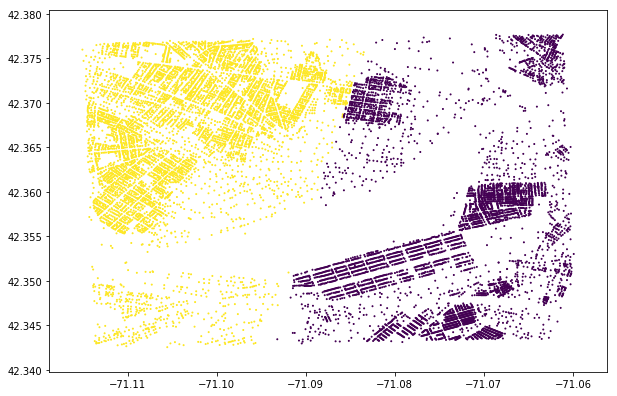

In [0]:
building_centers.plot(figsize=[10,10], column=kmeans_2, markersize=1)

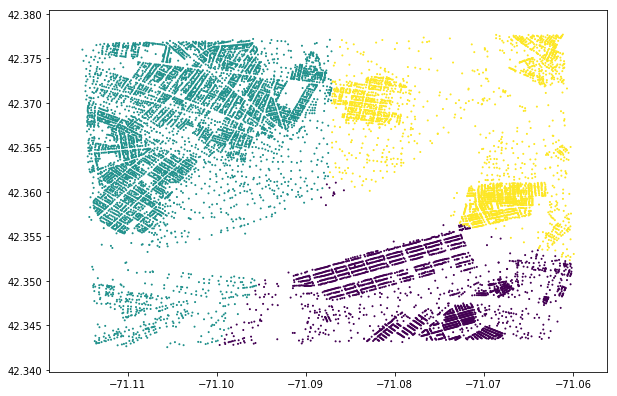

In [0]:
building_centers.plot(figsize=[10,10], column=kmeans_3, markersize=1)

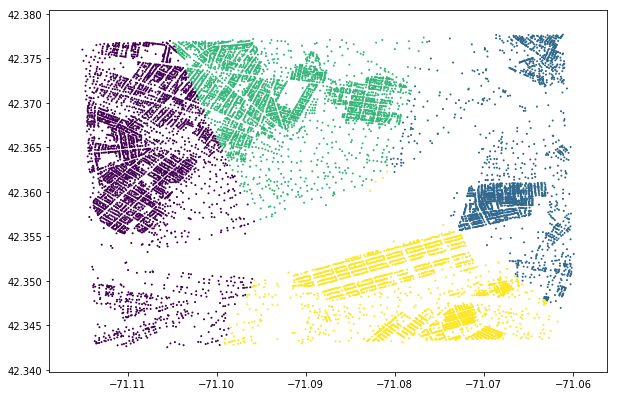

In [0]:
building_centers.plot(figsize=[10,10], column=kmeans_4, markersize=1)

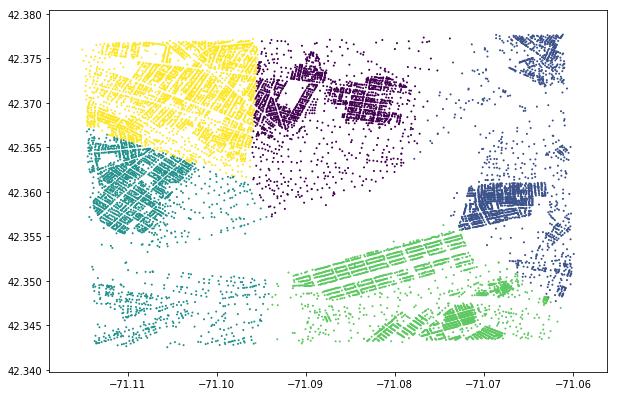

In [0]:
building_centers.plot(figsize=[10,10], column=kmeans_5, markersize=1)

## DBSCAN
DBSCAN looks for areas of high density separated by areas of lower density.

Need to manually select value of `eps` and `min_samples` as tuning variables.

[ 0 -1 -1 ...  3  3  3]


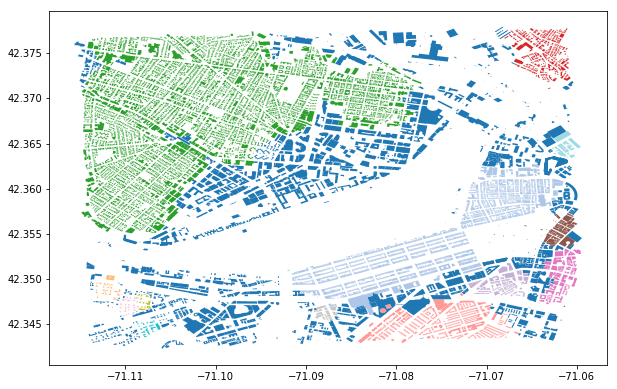

In [0]:
dbscan_class = DBSCAN(eps=0.001, min_samples=25).fit_predict(point_coords)
print(dbscan_class)
building_footprints.plot(figsize=[10,10], column=dbscan_class, markersize=0.05, cmap='tab20')

### OPTICS
[OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html#sklearn.cluster.OPTICS) is similar to DBSCAN, but keeps cluster hierarchy for a variable neighborhood radius.

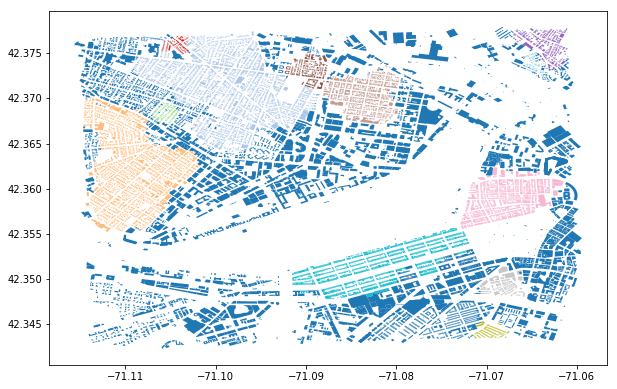

In [0]:
optics_class = OPTICS(min_samples=50, max_eps=0.001).fit_predict(point_coords)
building_footprints.plot(figsize=[10,10],column=optics_class, cmap='tab20')

## Agglomerative Hierarchical clustering
Agglomerative Hierarchical clustering forms clusters by starting all points off in their own cluster. Then clusters are merged together if they minimally increase a given "linkage" metric. This is done iteratively until the target number of clusters is reached, or a threshold metric value is reached.

The `n_clusters` and `distance_threshold` parameters need to be tuned manually.

The linkage types are:
- `ward` which minimizes the variance of the clusters eing merged
- `average` is the average of the distances of observations between sets
- `complete` or `maximum` uses the maximum distances between the observations of the two sets
- `single` uses the minimum distance between all observations of the two sets

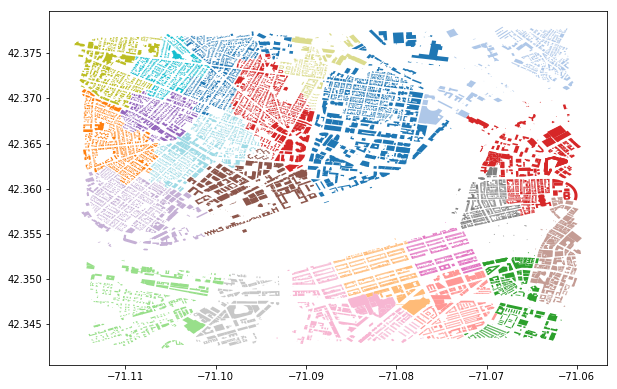

In [0]:
# can specify either distance threshold or n_clusters. Here we do distance_threshold
agg_class = AgglomerativeClustering(n_clusters=None,
                                    distance_threshold=0.1).fit_predict(point_coords)
building_footprints.plot(figsize=[10,10],column=agg_class, cmap='tab20')


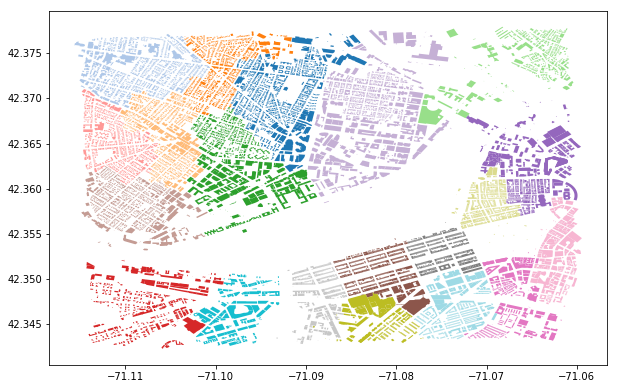

In [0]:
agg_class = AgglomerativeClustering(n_clusters=20).fit_predict(point_coords)
building_footprints.plot(figsize=[10,10],column=agg_class, cmap='tab20')


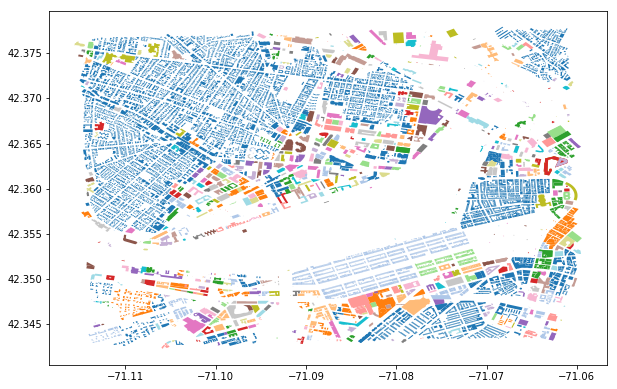

In [0]:
# using a different linkage (single)
agg_class = AgglomerativeClustering(n_clusters=None, linkage='single', 
                                    distance_threshold=0.0005).fit_predict(point_coords)
building_footprints.plot(figsize=[10,10],column=agg_class, cmap='tab20')

# Exercise
All of the classifiers so far uses the straight-line distance to compute the cluster distances. Many methods take a distance matrix as an optional argument, which allows us to specify alternative distance metrics.

In groups of 3, perform clustering on the building data using the road distance between points. Use the road information from osmnx. You will need to compute a distance matrix using the shortest route along the roads between each pair of points.

A distance matrix is an $N \times N$ matrix where the entry at location `i,j` represents the distance from node `i` to node `j`. 